# 3. Modelos e Análises

Nessa etapa serão implementados os modelos de classificação:
    * AdaBoost
    * RandomForest
    * Regressão Logística com otimização L2

In [1]:
# importações
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.externals import joblib

%matplotlib inline

#### Importação do conjunto de dados
Para avaliação dos modelos será necessário utilizar apenas o conjunto de treinamento. Por ser um desafio do Kaggle, o conjunto de teste é fornecido sem a classe, portanto não é possível obter métricas de validação dos modelos a partir desses dados.

In [2]:
# importa dataset de treino
ids = pd.read_csv('dataset/train_ids.csv')
target = pd.read_csv('dataset/train_target.csv')
features = scipy.sparse.load_npz('dataset/processed_train.npz')

In [3]:
# split em treino e teste
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(features, target, ids, test_size=0.3, shuffle=True)

#### Funções genéricas de treinamento e avaliação dos modelos

In [4]:
def treinamento(X_train, y_train, model_name):
    if model_name=='adaboost':
        model = AdaBoostClassifier()
    if model_name=='randomforest':
        model = RandomForestClassifier()
    if model_name=='logreg':
        model = LogisticRegression(penalty='l2', dual=True, C=0.3)
    
    model.fit(X_train,y_train)
    
    return model

In [5]:
def predict(X_test, model):
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    return pred, proba

In [11]:
def validation(X_test, y_test, proba, pred, model, model_name):
    #plt.ylabel('Feature Importance Score')
    with open(model_name+'_validation.txt', 'w') as f:
        print('Accuracy of the '+model_name+' on test set: {:.3f}'.format(model.score(X_test, y_test['target'])))
        print('Accuracy of the '+model_name+' on test set: {:.3f}'.format(model.score(X_test, y_test['target'])), file=f)

        print(metrics.classification_report(y_test['target'], pred))
        print(metrics.classification_report(y_test['target'], pred), file=f)

        print('F-score: '+str(metrics.f1_score(y_test['target'],pred)))
        print('F-score: '+str(metrics.f1_score(y_test['target'],pred)), file=f)
        
        fpr, tpr, thresholds = metrics.roc_curve(pred, y_test['target'])
        print('AUC: ' + str(metrics.auc(fpr, tpr)))
        print('AUC: ' + str(metrics.auc(fpr, tpr)), file=f)
        
        cm = metrics.confusion_matrix(y_test, pred)
        print(pd.DataFrame({'Real Não Confiável': [cm[0,0],cm[1,0]],'Real Confiável': [cm[0,1],cm[1,1]]},index=['Predict Não Confiável', 'Predict Confiável']))
        print(pd.DataFrame({'Real Não Confiável': [cm[0,0],cm[1,0]],'Real Confiável': [cm[0,1],cm[1,1]]},index=['Predict Não Confiável', 'Predict Confiável']), file=f)
    return None

def plot_roc_curve(y_score, y_true, model_name):
    fpr,tpr,thr = metrics.roc_curve(y_score=y_score,y_true=y_true)
    roc_auc = metrics.auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="best")
    plt.savefig(model_name+'_roc_curve.png')
    return fpr,tpr,thr

def ks_test(decision, y_test, model_name):
    scores = pd.DataFrame(
        {'scores': decision,
         'y': y_test
         })
    bad = scores[scores['y']==0]
    good = scores[scores['y']==1]
    
    valuesb, baseb = np.histogram(bad['scores'],2000)
    valuesg, baseg = np.histogram(good['scores'],2000)
    
    ks = scipy.stats.ks_2samp(bad['scores'], good['scores'])
    print(ks)
    # evaluate the cumulative
    cumulativeB = np.cumsum(valuesb)
    cumulativeG = np.cumsum(valuesg)
    cumBperc = (cumulativeB / cumulativeB[-1]) * 100
    cumGperc = (cumulativeG / cumulativeG[-1]) * 100

    # plot the cumulative function
    plt.figure()
    plt.plot(baseb[:-1], cumBperc, c='blue', label='Bad')
    plt.plot(baseg[:-1], cumGperc, c='green', label='Good')
    plt.title('Kolmogorov–Smirnov Test')
    text = 'KS = %0.2f' % ks.statistic
    plt.text(0.05, 90, text)
    plt.savefig(model_name+'_ks_test.png')
    # https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html
    print(text)

### Adaboost

In [7]:
model_name = 'adaboost'
model = treinamento(X_train, y_train.values.ravel(), model_name)

In [8]:
pred, proba = predict(X_test, model)

In [9]:
validation(X_test, y_test, proba, pred, model, model_name)

Accuracy of the adaboost on test set: 0.963
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3136
           1       0.95      0.97      0.96      2966

   micro avg       0.96      0.96      0.96      6102
   macro avg       0.96      0.96      0.96      6102
weighted avg       0.96      0.96      0.96      6102

F-score: 0.9625793518209155
AUC: 0.9631970080493014
                       Real Não Confiável  Real Confiável
Predict Não Confiável                2997             139
Predict Confiável                      85            2881


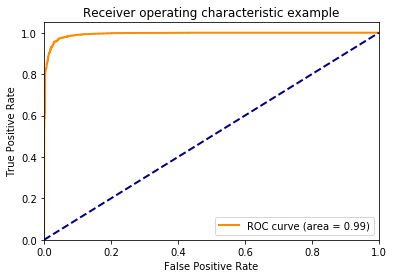

In [12]:
fpr,tpr,thr = plot_roc_curve(proba[:,1], y_test['target'], model_name)

Ks_2sampResult(statistic=0.9273367725377407, pvalue=0.0)
KS = 0.93


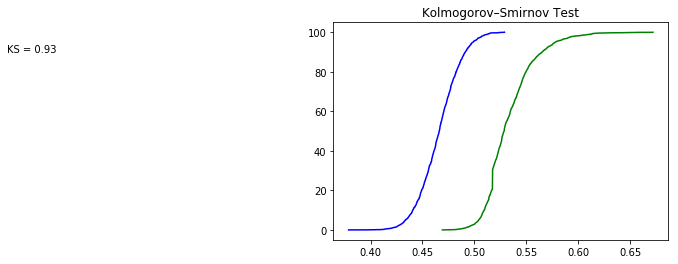

In [13]:
ks_test(proba[:,1],y_test['target'], model_name)

In [14]:
joblib.dump(model, model_name+'.pkl')

['adaboost.pkl']

### Random Forest

In [15]:
model_name = 'randomforest'
model = treinamento(X_train, y_train.values.ravel(), model_name)

c:\users\prisk\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [16]:
pred, proba = predict(X_test, model)

In [17]:
validation(X_test, y_test, proba, pred, model, model_name)

Accuracy of the randomforest on test set: 0.873
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3136
           1       0.92      0.81      0.86      2966

   micro avg       0.87      0.87      0.87      6102
   macro avg       0.88      0.87      0.87      6102
weighted avg       0.88      0.87      0.87      6102

F-score: 0.8620936048588781
AUC: 0.8787136594167987
                       Real Não Confiável  Real Confiável
Predict Não Confiável                2917             219
Predict Confiável                     553            2413


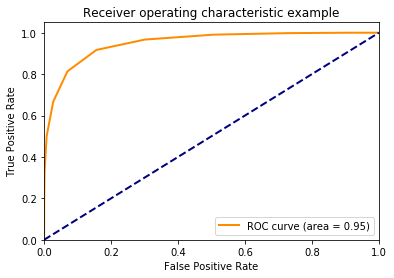

In [18]:
fpr,tpr,thr = plot_roc_curve(proba[:,1], y_test['target'], model_name)

Ks_2sampResult(statistic=0.7604728590694538, pvalue=0.0)
KS = 0.76


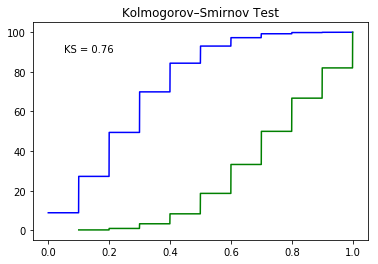

In [19]:
ks_test(proba[:,1],y_test['target'], model_name)

In [20]:
joblib.dump(model, model_name+'.pkl')

['randomforest.pkl']

### Logistic Regression

In [21]:
model_name = 'logreg'
model = treinamento(X_train, y_train.values.ravel(), model_name)

c:\users\prisk\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
pred, proba = predict(X_test, model)

In [23]:
validation(X_test, y_test, proba, pred, model, model_name)

Accuracy of the logreg on test set: 0.942
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3136
           1       0.93      0.95      0.94      2966

   micro avg       0.94      0.94      0.94      6102
   macro avg       0.94      0.94      0.94      6102
weighted avg       0.94      0.94      0.94      6102

F-score: 0.941156914893617
AUC: 0.9419817158326709
                       Real Não Confiável  Real Confiável
Predict Não Confiável                2917             219
Predict Confiável                     135            2831


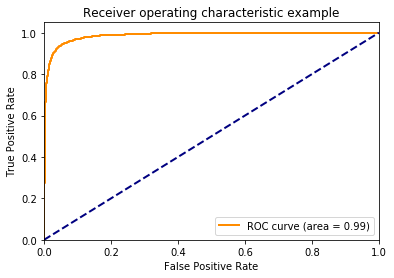

In [24]:
fpr,tpr,thr = plot_roc_curve(proba[:,1], y_test['target'], model_name)

Ks_2sampResult(statistic=0.8912429730826923, pvalue=0.0)
KS = 0.89


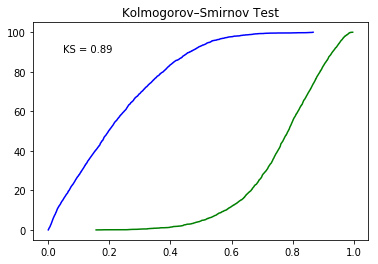

In [25]:
ks_test(proba[:,1],y_test['target'], model_name)

In [26]:
joblib.dump(model, model_name+'.pkl')

['logreg.pkl']

### Preparação da submissão para o Kaggle
Para submeter os 3 modelos no kaggle, eles serão treinados utilizando o conjunto de treinamento disponibilizado inteiro e será feita a predição do conjunto de teste. O resultado dessa predição será salvo em um arquivo no formato CSV e submetido ao kaggle.

In [29]:
X_train = features
X_test = scipy.sparse.load_npz('dataset/processed_test.npz')
y_train = target
ids_train = ids
#ids_test = pd.read_csv('dataset/test_ids.csv')

In [36]:
model_name = 'adaboost'
model = treinamento(X_train, y_train.values.ravel(), model_name)
pred = model.transform(X_test)
#pred, proba = predict(X_test, model)
pd.DataFrame(pred,columns=['predictions']).to_csv(model_name+'_result.csv',index=False)

AttributeError: 'AdaBoostClassifier' object has no attribute 'transform'

In [34]:
from scipy.sparse import hstack
X_train = hstack((X_train,np.array(pd.)[:,None]))
X_train_dtm = hstack((X_train_dtm,np.array(X_train['wordcount'])[:,None]))

train_df = pd.read_csv("Cinderella.csv")
train_df['label'] = 'train'

score_df = pandas.read_csv("Slaughterhouse_copy.csv")
score_df['label'] = 'score'

# Concat
concat_df = pd.concat([train_df , score_df])

# Create your dummies
features_df = pd.get_dummies(concat_df, columns=['Overall_Sentiment', 'Word_1','Word_2','Word_3','Word_4','Word_5','Word_6','Word_7','Word_8','Word_9','Word_10','Word_11','Word_1','Word_12','Word_13','Word_14','Word_15','Word_16','Word_17','Word_18','Word_19','Word_20','Word_21','Word_22','Word_23','Word_24','Word_25','Word_26','Word_27','Word_28','Word_29','Word_30','Word_31','Word_32','Word_33','Word_34','Word_35','Word_36','Word_37','Word_38','Word_39','Word_40','Word_41', 'Word_42', 'Word_43'], dummy_na=True)

# Split your data
train_df = features_df[features_df['label'] == 'train']
score_df = features_df[features_df['label'] == 'score']

# Drop your labels
train_df = train_df.drop('label', axis=1)
score_df = score_df.drop('label', axis=1)

(5106, 66718)

In [ ]:
pd.Series()